In [6]:
#pip3 install geopandas
#pip3 install folium

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import numpy as np

In [7]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Load CSVs
ee = pd.read_csv("WDAC_2025_data/TrainStationEntriesExits/train-station-entries-exits-data-may-2025.csv")
stations = pd.read_csv("WDAC_2025_data/TrainStationEntranceLocations/stationentrances2020_v4.csv")


In [8]:
print(ee.columns)
ee = ee.rename(columns={'Station_Type ' : 'Station_Type', 'MonthYear' : 'Month_Year'})
print(ee.columns)

Index(['MonthYear', 'Station', 'Station_Type ', 'Entry_Exit', 'Trip'], dtype='object')
Index(['Month_Year', 'Station', 'Station_Type', 'Entry_Exit', 'Trip'], dtype='object')


In [9]:
# 2. Clean and filter
stations_to_ignore = ["Rosehill", "Camellia", "Rydalmere", "Dundas", "Telopea", "Carlingford"]

ee = ee[ee["Station_Type"].isin(["train", "Metro Shared"])].copy()
ee["Train_Station"] = ee["Station"].str.replace(" Station", "", regex=False).str.strip()
ee = ee[~ee["Train_Station"].isin(stations_to_ignore)]
ee["TripNumber"] = ee["Trip"].replace("Less than 50", 50).astype(float)

# 3. Keep one location per station
stations = stations[~stations.duplicated("Train_Station")]
stations = stations[stations["Train_Station"].isin(ee["Train_Station"])]

# 4. Merge coordinates
ee = ee.merge(stations[["Train_Station", "LAT", "LONG"]], on="Train_Station", how="left")

# 5. Filter to Entry + May-25
ee_map = ee[(ee["Month_Year"] == "May-25") & (ee["Entry_Exit"] == "Entry")].copy()
ee_map["log10Trips"] = np.log10(ee_map["TripNumber"])

# 6. Convert to GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    ee_map,
    geometry=gpd.points_from_xy(ee_map["LONG"], ee_map["LAT"]),
    crs="EPSG:4326"
)

print(len(gdf_points))

# 7. Read Sydney train routes shapefile
train_routes = gpd.read_file("WDAC_2025_data/SydneyTrainRoutes/sydneytrains/SydneyTrains.shp")
train_routes = train_routes.to_crs("EPSG:4326")

# 8. Base map with Folium (interactive)
m = folium.Map(location=[-33.87, 151.1], zoom_start=11, tiles='cartodbpositron')

# 9. Add train routes
for _, row in train_routes.iterrows():
    if row.geometry.type == "LineString":
        coords = [(lat, lon) for lon, lat in row.geometry.coords]
        folium.PolyLine(coords, color="red", weight=2).add_to(m)

print(gdf_points[["Train_Station", "LAT", "LONG"]].isna().sum())

# Import matplotlib for colormap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 10. Add stations with color-coded markers
# Remove any rows with missing coordinates
gdf_points_clean = gdf_points.dropna(subset=['LAT', 'LONG'])

if len(gdf_points_clean) > 0:
    for _, row in gdf_points_clean.iterrows():
        # Normalize and convert to hex color
        norm_value = row["log10Trips"] / gdf_points_clean["log10Trips"].max()
        rgba = plt.cm.viridis(norm_value)
        hex_color = mcolors.to_hex(rgba)

        folium.CircleMarker(
            location=[row["LAT"], row["LONG"]],
            radius=8,  # Made slightly larger for better visibility
            popup=f"{row['Train_Station']}<br>Trips: {int(row['TripNumber'])}<br>Log10 Trips: {row['log10Trips']:.2f}",
            color=hex_color,
            fill=True,
            fill_color=hex_color,
            fill_opacity=0.8,
            weight=2
        ).add_to(m)
else:
    print("Warning: No valid station coordinates found!")

# 11. Show the map
m.save("train_station_map.html")
m

291
Train_Station     0
LAT              11
LONG             11
dtype: int64


In [15]:
import pandas as pd
import os

# ✅ Set path to folder with Opal_Patronage_*.txt files
data_folder = "./WDAC_2025_data/OpalPatronage"

# 🔎 List all Opal_Patronage txt files
file_list = [f for f in os.listdir(data_folder) if f.endswith('.txt') and 'Opal_Patronage' in f]

df_list = []

for file in file_list:
    file_path = os.path.join(data_folder, file)
    temp_df = pd.read_csv(file_path, sep='|')

    # Clean column names
    temp_df.columns = temp_df.columns.str.strip().str.lower()

    # Lowercase + strip all string columns
    temp_df = temp_df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

    # Convert trip_origin_date to datetime
    temp_df['trip_origin_date'] = pd.to_datetime(temp_df['trip_origin_date'])

    # Replace '<50', '<100', etc. with numeric and convert
    temp_df['tap_ons'] = temp_df['tap_ons'].replace(to_replace=r'<(\d+)', value=r'\1', regex=True).astype(int)
    temp_df['tap_offs'] = temp_df['tap_offs'].replace(to_replace=r'<(\d+)', value=r'\1', regex=True).astype(int)

    # Add year, month, day columns
    temp_df['year'] = temp_df['trip_origin_date'].dt.year
    temp_df['month'] = temp_df['trip_origin_date'].dt.month
    temp_df['day'] = temp_df['trip_origin_date'].dt.day

    # Add total trip count
    temp_df['trip_count'] = temp_df['tap_ons'] + temp_df['tap_offs']

    df_list.append(temp_df)

# 📦 Combine all files into one DataFrame
opal_df = pd.concat(df_list, ignore_index=True)

# 🔍 Null value check
null_summary = opal_df.isnull().sum()
print("Null Values Per Column:\n", null_summary)

# 🧹 Drop rows with any null values
opal_df = opal_df.dropna()

# 💾 Save cleaned data
opal_df.to_csv("opal_patronage_cleaned.csv", index=False)

# 👀 Preview
opal_df.head()


Null Values Per Column:
 trip_origin_date    0
mode_name           0
ti_region           0
tap_hour            0
tap_ons             0
tap_offs            0
year                0
month               0
day                 0
trip_count          0
dtype: int64


,trip_origin_date,mode_name,ti_region,tap_hour,tap_ons,tap_offs,year,month,day,trip_count
0,2024-11-12,bus,chatswood,0,100,100,2024,11,12,200
1,2024-11-12,bus,macquarie park,0,100,100,2024,11,12,200
2,2024-11-12,bus,newcastle and surrounds,0,100,100,2024,11,12,200
3,2024-11-12,bus,north sydney,0,100,100,2024,11,12,200
4,2024-11-12,bus,other,0,800,1100,2024,11,12,1900


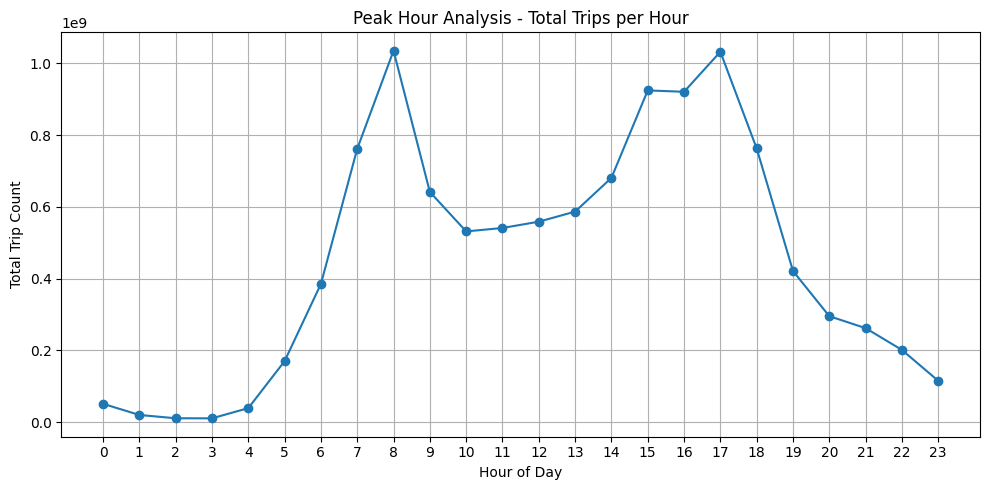

In [16]:
import matplotlib.pyplot as plt

# Group by hour
peak_hour = opal_df.groupby('tap_hour')['trip_count'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(peak_hour['tap_hour'], peak_hour['trip_count'], marker='o')
plt.title('Peak Hour Analysis - Total Trips per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Trip Count')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


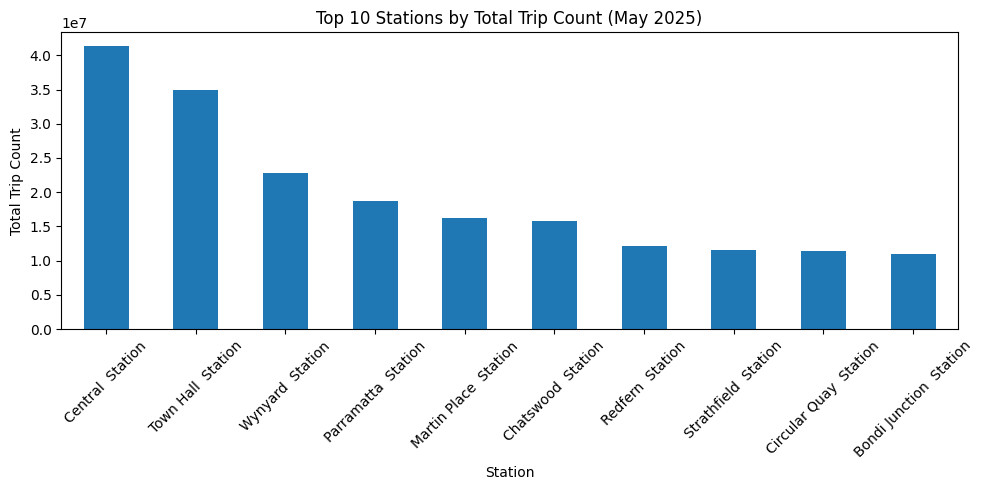

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
path = "./WDAC_2025_data/TrainStationEntriesExits/train-station-entries-exits-data-may-2025.csv"
df = pd.read_csv(path)

# Clean columns
df.columns = df.columns.str.strip().str.lower()

# Convert trip to numeric (handle '<50')
df['trip'] = df['trip'].replace({'Less than 50': '50'}).astype(int)

# Group by station and sum trips
station_rank = df.groupby('station')['trip'].sum().sort_values(ascending=False).reset_index()

# Plot top 10 stations
station_rank.head(10).plot(kind='bar', x='station', y='trip', figsize=(10,5), legend=False)
plt.title("Top 10 Stations by Total Trip Count (May 2025)")
plt.ylabel("Total Trip Count")
plt.xlabel("Station")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


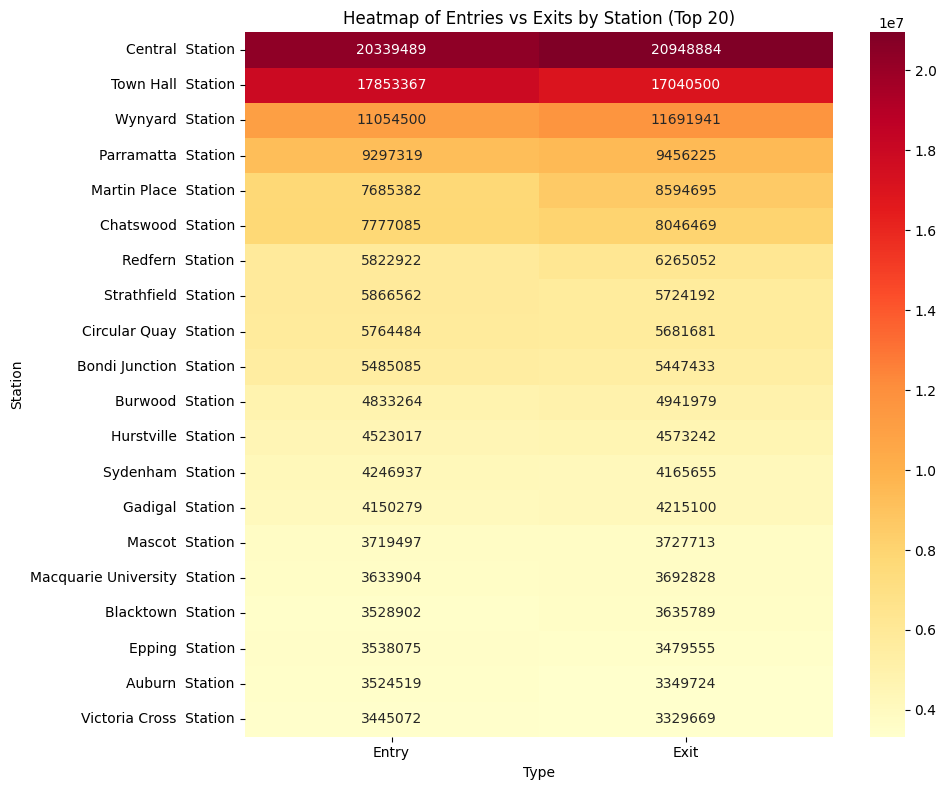

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
path = "./WDAC_2025_data/TrainStationEntriesExits/train-station-entries-exits-data-may-2025.csv"
df = pd.read_csv(path)

# Clean columns
df.columns = df.columns.str.strip().str.lower()

# Clean trip column
df['trip'] = df['trip'].replace({'Less than 50': '50'}).astype(int)

# Create pivot table: rows = stations, columns = entry/exit, values = trip counts
heatmap_data = df.pivot_table(
    index='station',
    columns='entry_exit',
    values='trip',
    aggfunc='sum',
    fill_value=0
)

# Sort stations by total volume (for visual clarity)
heatmap_data['total'] = heatmap_data.sum(axis=1)
heatmap_data = heatmap_data.sort_values(by='total', ascending=False).drop(columns='total')

# Limit to top 20 stations
heatmap_data = heatmap_data.head(20)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Heatmap of Entries vs Exits by Station (Top 20)')
plt.xlabel('Type')
plt.ylabel('Station')
plt.tight_layout()
plt.show()


In [53]:
import pandas as pd

# Load the file
path = "./WDAC_2025_data/TrainStationEntriesExits/train-station-entries-exits-data-may-2025.csv"
df = pd.read_csv(path)

# Show all columns
print(df.columns.tolist())

# Show first 5 rows
print(df.head())


['MonthYear', 'Station', 'Station_Type ', 'Entry_Exit', 'Trip']
  MonthYear               Station Station_Type  Entry_Exit          Trip
0    Aug-24     Aberdeen  Station         train      Entry  Less than 50
1    Aug-24     Aberdeen  Station         train       Exit  Less than 50
2    Aug-24    Adamstown  Station         train      Entry          2585
3    Aug-24    Adamstown  Station         train       Exit          2391
4    Aug-24  Albion Park  Station         train      Entry          6919


In [54]:
# Assumption: Fewer trips → higher wait time, we estimate "wait time" inversely
wait_time_estimate = (
    opal_df.groupby('ti_region')['trip_count']
    .mean()
    .reset_index()
    .rename(columns={'trip_count': 'avg_trip_count'})
)
wait_time_estimate['estimated_avg_wait_min'] = (1 / wait_time_estimate['avg_trip_count']) * 1000  # heuristic scale

# Top 10 regions with highest estimated wait
wait_time_estimate.sort_values(by='estimated_avg_wait_min', ascending=False).head(10)


,ti_region,avg_trip_count,estimated_avg_wait_min
3,newcastle and surrounds,171.064305,5.845755
9,wollongong and surrounds,341.918120,2.924677
4,north sydney,807.316380,1.238672
2,macquarie park,810.408517,1.233946
7,strathfield,870.637001,1.148584
1,chatswood,1053.410510,0.949298
6,parramatta,1467.076607,0.681628
8,sydney cbd,6801.888153,0.147018
5,other,17822.567196,0.056109
0,all - nsw,26440.669015,0.037821


In [55]:
# Daily total trips
daily_trips = opal_df.groupby('trip_origin_date')['trip_count'].sum().reset_index()

# Simple forecast using linear regression
from sklearn.linear_model import LinearRegression
import numpy as np

# Encode dates
daily_trips['day_num'] = (daily_trips['trip_origin_date'] - daily_trips['trip_origin_date'].min()).dt.days
X = daily_trips[['day_num']]
y = daily_trips['trip_count']

# Train model
model = LinearRegression()
model.fit(X, y)

# Predict next 30 days
future_days = pd.DataFrame({'day_num': range(X['day_num'].max() + 1, X['day_num'].max() + 31)})
future_days['trip_origin_date'] = daily_trips['trip_origin_date'].max() + pd.to_timedelta(future_days['day_num'] - X['day_num'].max(), unit='D')
future_days['predicted_trip_count'] = model.predict(future_days[['day_num']])

# Plot
plt.figure(figsize=(12,6))
plt.plot(daily_trips['trip_origin_date'], daily_trips['trip_count'], label='Actual')
plt.plot(future_days['trip_origin_date'], future_days['predicted_trip_count'], label='Forecast', linestyle='--')
plt.title("Forecast of Daily Trip Count (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Trip Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'sklearn'